In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
def gauss_2d(mu1x, mu2x, mu1y, mu2y, sigma, ncount, tau1, tau2):
    x1 = np.random.normal(mu1x, sigma, tau1)
    y1 = np.random.normal(mu1y, sigma, tau2)
    x2 = np.random.normal(mu2x, sigma, ncount-tau1)
    y2 = np.random.normal(mu2y, sigma, ncount-tau2)
    x = np.concatenate((x1, x2))
    y = np.concatenate((y1, y2))
    h1 = np.array([0 if i<tau1 else 1 for i in range(ncount)])
    h2 = np.array([0 if i<tau2 else 1 for i in range(ncount)])
    data = np.vstack((x, y, h1, h2))
    return np.transpose(data).astype('float32')

In [3]:
np_data = gauss_2d(0, 2, 1, 3, 2, 1000, 700, 600)
df = pd.DataFrame(np_data, columns=['x', 'y', 'hx', 'hy'])
df.head()

,x,y,hx,hy
0,-0.591862,3.140268,0.0,0.0
1,-2.165490,1.491860,0.0,0.0
2,0.649382,-1.325860,0.0,0.0
3,-3.380709,1.102147,0.0,0.0
4,4.498743,0.602086,0.0,0.0


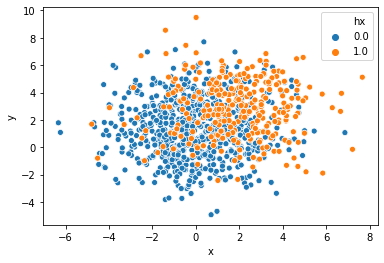

In [4]:
sns.scatterplot(x='x', y='y', data=df, hue='hx')

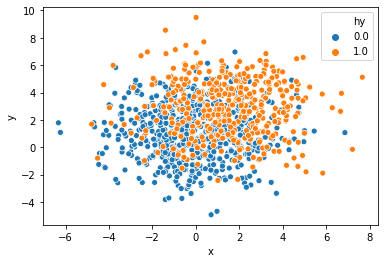

In [5]:
sns.scatterplot(x='x', y='y', data=df, hue='hy')

In [6]:
nrows, ncols = np_data.shape[0], np_data.shape[1]-1

In [7]:
nrows, ncols

(1000, 3)

In [8]:
# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(np_data[:,0]), tf.float32) * tf.ones([], dtype=tf.float32, name="init_mu1_x"),
    tf.cast(tf.reduce_mean(np_data[:,1]), tf.float32) * tf.ones([], dtype=tf.float32, name="init_mu2_x"),
    tf.cast(tf.reduce_mean(np_data[:,0]), tf.float32) * tf.ones([], dtype=tf.float32, name="init_mu1_y"),
    tf.cast(tf.reduce_mean(np_data[:,1]), tf.float32) * tf.ones([], dtype=tf.float32, name="init_mu2_y"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau1"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau2"),
]

In [9]:
# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),  # Maps a positive real to R.
    tfp.bijectors.Identity(),       # Maps a positive real to R.
    tfp.bijectors.Identity(),       # Maps a positive real to R.
    tfp.bijectors.Identity(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

In [10]:
def joint_log_prob(data, mu1_x, mu2_x,  mu1_y, mu2_y, tau1, tau2):
    tfd = tfp.distributions
 
    alpha_mu_x = tf.reduce_mean(data[:,0])
    alpha_sigma_x = tf.math.reduce_std(data[:,0])
    alpha_mu_y = tf.reduce_mean(data[:,1])
    alpha_sigma_y = tf.math.reduce_std(data[:,1])
    
    rv_mu_1_x = tfd.Normal(loc=alpha_mu_x, scale=alpha_sigma_x)
    rv_mu_2_x = tfd.Normal(loc=alpha_mu_x, scale=alpha_sigma_x)
    rv_mu_1_y = tfd.Normal(loc=alpha_mu_y, scale=alpha_sigma_y)
    rv_mu_2_y = tfd.Normal(loc=alpha_mu_y, scale=alpha_sigma_y)
 
    rv_tau_1 = tfd.Uniform()
    rv_tau_2 = tfd.Uniform()
 
    n1_vars = tf.gather(
         [mu1_x, mu2_x],
         indices=tf.compat.v1.to_int32(tau1 * tf.cast(tf.size(data[:,0]), tf.float32) <= 
                                       tf.cast(tf.range(tf.size(data[:,0])), tf.float32)))
    rv_observation_x = tfd.Normal(loc=n1_vars, scale=alpha_sigma_x)
    
    n2_vars = tf.gather(
         [mu1_y, mu2_y],
         indices=tf.compat.v1.to_int32(tau2 * tf.cast(tf.size(data[:,1]), tf.float32) <= 
                                       tf.cast(tf.range(tf.size(data[:,1])), tf.float32)))
    rv_observation_y = tfd.Normal(loc=n2_vars, scale=alpha_sigma_y)
 
    return (
         rv_mu_1_x.log_prob(mu1_x)
         + rv_mu_2_x.log_prob(mu2_x) 
         + rv_mu_1_y.log_prob(mu1_y)
         + rv_mu_2_y.log_prob(mu2_y)
         + rv_tau_1.log_prob(tau1) + rv_tau_2.log_prob(tau2)
         + tf.reduce_sum(rv_observation_x.log_prob(data[:,0]))
         + tf.reduce_sum(rv_observation_y.log_prob(data[:,1]))
    )

In [11]:
# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(mu1_x, mu2_x, mu1_y, mu2_y, tau1, tau2):
    return joint_log_prob(np_data, mu1_x, mu2_x, mu1_y, mu2_y, tau1, tau2)

In [12]:
# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

In [13]:
# Sample from the chain.
[
    mu1_x_samples, mu2_x_samples, 
    mu1_y_samples, mu2_y_samples, 
    posterior_tau1, posterior_tau2
], kernel_results = tfp.mcmc.sample_chain(
    num_results=100000,
    num_burnin_steps=10000,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors))

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.identity instead.


/home/a635137/pplenv/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/internal/util.py:521: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/home/a635137/pplenv/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [14]:
tau_samples1 = tf.floor(posterior_tau1 * tf.cast(tf.size(np_data[:,0]), tf.float32))
tau_samples2 = tf.floor(posterior_tau2 * tf.cast(tf.size(np_data[:,1]), tf.float32))

In [15]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.compat.v1.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

In [16]:
# evaluate(init_g)
# evaluate(init_l)
[
    mu1_x_samples_,
    mu2_x_samples_,
    mu1_y_samples_,
    mu2_y_samples_,
    posterior_tau1_, posterior_tau2_,
    kernel_results_,
] = evaluate([
    mu1_x_samples,
    mu2_x_samples,
    mu1_y_samples,
    mu2_y_samples,
    tau_samples1, tau_samples2,
    kernel_results
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()) if len(kernel_results_.inner_results.extra)>0 else 'NA')

acceptance rate: 0.02002
NA


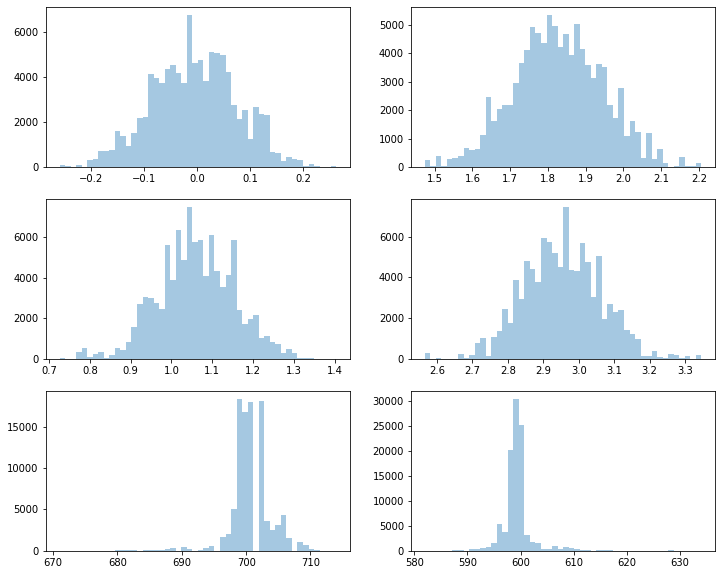

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

sns.distplot(mu1_x_samples_, ax=axs[0][0], kde=False)
sns.distplot(mu2_x_samples_, ax=axs[0][1], kde=False)
sns.distplot(mu1_y_samples_, ax=axs[1][0], kde=False)
sns.distplot(mu2_y_samples_, ax=axs[1][1], kde=False)
sns.distplot(posterior_tau1_, ax=axs[2][0], kde=False)
sns.distplot(posterior_tau2_, ax=axs[2][1], kde=False)